In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from scdna_replication_tools.plot_utils import get_metacohort_cmaps

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 5
despine_trim = True

### Load and plot the clustered heatmap of clone RT correlations

In [3]:
def load_encode_repliseq():
    columns = [
        'chr',
        'start',
        'end',
        'mcf7_rt',
        'bg02es_rt',
        'bj_rt',
        'gm06990_rt',
        'gm12801_rt',
        'gm12812_rt',
        'gm12813_rt',
        'gm12878_rt',
        'helas3_rt',
        'hepg2_rt',
        'huvec_rt',
        'imr90_rt',
        'k562_rt',
        'sknsh_rt',
        'nhek_rt',
    ]

    encode_filename = '/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/simulation/D1.0/s_phase_cells_pyro_composite_filtered.tsv'
    encode = pd.read_csv(encode_filename, sep='\t', low_memory=True, usecols=columns).drop_duplicates()
    encode['start'] += 1
    encode = encode.set_index(['chr', 'start', 'end']).T
    
    return encode


def load_clone_rt_and_features(remove=[]):
    clone_rt = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/clone_rt.csv.gz', low_memory=False)
    features = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/features.csv.gz', low_memory=False)

    features['clone'] = features['dataset'] + '_clone' + features['clone_id']
    features = features.set_index('clone')
    features['signature_NA'] = 1 - features.filter(regex='signature_.*', axis=1).sum(axis=1)
    features['wgd'] = (features['ploidy'] > 2) * 1

    clone_rt = clone_rt.set_index(['chr', 'start', 'end']).T
    clone_rt.index = [a.replace('pseudobulk_', '').replace('_model_rep_state', '') for a in clone_rt.index]

    # filter based on the remove list
    clone_rt = clone_rt[~clone_rt.index.isin(remove)]
    features = features.reindex(clone_rt.index)

    # filter based on the number of cells
    features = features[features['num_cells_s'] >= 20]
    clone_rt = clone_rt.reindex(features.index)

    # create the full features dataframe
    # ploidy
    features_ploidy = features['ploidy'].astype('int').astype('str').to_frame()
    # wgd
    features_wgd = features['wgd'].to_frame()
    # signature
    assert (features.filter(regex='signature_.*', axis=1).sum(axis=1) == 1).all()
    features_signature = features.filter(regex='signature_.*', axis=1).melt(var_name='signature', value_name='indicator', ignore_index=False)
    features_signature = features_signature[features_signature['indicator'] == 1]
    features_signature['signature'] = features_signature['signature'].str.replace('signature_', '')
    features_signature = features_signature.drop('indicator', axis=1)
    features_signature = features_signature.reindex(clone_rt.index, fill_value='NA')
    # cell type
    features_type = features.filter(regex='type_.*', axis=1).melt(var_name='type', value_name='indicator', ignore_index=False)
    features_type = features_type[features_type['indicator'] == 1]
    features_type['type'] = features_type['type'].str.replace('type_', '')
    features_type = features_type.drop('indicator', axis=1)
    # dataset
    features_dataset = features['dataset'].to_frame()

    # combine all features
    features_df = pd.concat([features_type, features_signature, features_dataset, features_ploidy, features_wgd], axis=1).fillna('N/A')
    features_df.index.name = 'clone'

    return clone_rt, features_df


def load_combined_rt(remove=[]):
    encode = load_encode_repliseq()
    clone_rt, features_df = load_clone_rt_and_features(remove=remove)
    merged_index = encode.columns.intersection(clone_rt.columns)
    combined = pd.concat([
        encode.loc[:, merged_index],
        clone_rt.loc[:, merged_index],
    ], axis=0)
    return combined, features_df


In [4]:
clone_rt, features_df = load_clone_rt_and_features()

In [5]:
# Get unique attributes and sort them
def get_colors(df, palettes):
    colors = df[palettes.keys()].copy()
    print(colors)
    attribute_to_color = dict()
    for col, pal in palettes.items():
        # unique_attrs = sorted(colors[col].unique())
        # print(unique_attrs)
        # cmap = sns.color_palette(palette=pal)
        attribute_to_color[col] = pal
        colors[col] = colors[col].map(pal)
    return colors, attribute_to_color

cell_type_cdict, signature_cdict, condition_cdict, ploidy_cdict, sample_cdict = get_metacohort_cmaps(return_cdicts=True)
palettes = {
    'type': cell_type_cdict,
    'signature': signature_cdict,
    'ploidy': ploidy_cdict,
    'dataset': sample_cdict,
}

col_colors, attribute_to_color = get_colors(features_df, palettes)

                   type signature ploidy  dataset
clone                                            
GM18507_cloneA  GM18507        NA      2  GM18507
SA1096_cloneA     HGSOC       FBI      2   SA1096
SA1096_cloneB     HGSOC       FBI      3   SA1096
SA1096_cloneG     HGSOC       FBI      4   SA1096
SA1049_cloneA     HGSOC       FBI      3   SA1049
...                 ...       ...    ...      ...
SA906b_cloneJ     hTERT        NA      2   SA906b
SA906b_cloneK     hTERT        NA      2   SA906b
SA906b_cloneL     hTERT        NA      2   SA906b
SA1056_cloneA     hTERT        NA      2   SA1056
SA1056_cloneB     hTERT        NA      2   SA1056

[102 rows x 4 columns]


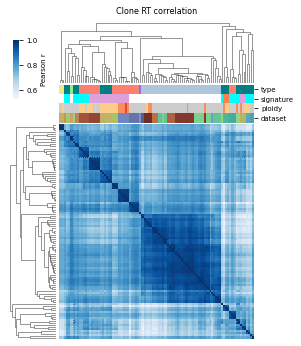

In [17]:
# # Get unique attributes and sort them
# def get_colors(df, palettes):
#     colors = df[palettes.keys()].copy()
#     attribute_to_color = dict()
#     for col in palettes.keys():
#         unique_attrs = sorted(colors[col].unique())
#         cmap = sns.color_palette(palette=palettes[col], n_colors=len(unique_attrs))
#         attribute_to_color[col] = dict(zip(unique_attrs, cmap))
#         colors[col] = colors[col].map(attribute_to_color[col])
#     return colors, attribute_to_color

# cell_type_cdict, signature_cdict, condition_cdict, ploidy_cdict, sample_cdict = get_metacohort_cmaps(return_cdicts=True)
# palettes = {
#     'type': 'tab10',
#     'signature': 'bright',
#     'ploidy': 'mako',
#     'dataset': 'tab20',
# }

def get_colors(df, palettes):
    df['ploidy'] = df['ploidy'].astype(int)
    colors = df[palettes.keys()].copy()
    attribute_to_color = dict()
    for col, pal in palettes.items():
        unique_attrs = sorted(colors[col].unique())
        # subset pal to just the keys that appear in unique_attrs
        attribute_to_color[col] = dict((k, pal[k]) for k in unique_attrs)
        colors[col] = colors[col].map(pal)
    return colors, attribute_to_color

cell_type_cdict, signature_cdict, condition_cdict, ploidy_cdict, sample_cdict = get_metacohort_cmaps(return_cdicts=True)
palettes = {
    'type': cell_type_cdict,
    'signature': signature_cdict,
    'ploidy': ploidy_cdict,
    'dataset': sample_cdict,
}

col_colors, attribute_to_color = get_colors(features_df, palettes)

clone_rt_corr = clone_rt.T.corr()
clone_rt_dism = 1 - clone_rt_corr
linkage = hc.linkage(sp.distance.squareform(clone_rt_dism), method='average')
g = sns.clustermap(
    clone_rt_corr, row_linkage=linkage, col_linkage=linkage, 
    cmap='Blues', col_colors=col_colors, figsize=(4.5, 5.5),
    cbar_pos=(0.04, 0.78, 0.02, 0.15),
    cbar_kws={'label': 'Pearson r'},
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_dendrogram.set_title('Clone RT correlation')

# for feature in attribute_to_color.keys():
#     plt.figure(figsize=(4, 1))
#     ax = plt.gca()
#     for attribute, color in attribute_to_color[feature].items():
#         ax.bar(0, 0, color=color, label=attribute, linewidth=0)
#     ax.legend(loc='center', ncol=7, bbox_to_anchor=(0.5, 0.5), title=feature)
#     ax.axis('off')

g.savefig('scdna_replication_paper/manuscript/main_figs/fig4_heatmap.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
clone_rt_corr.shape

(102, 102)